# Spaceship Titanic

Welcome to the year 2912, where our data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

## 1. Import the libraries

In [57]:
import pandas as pd  # pandas is used for data manipulation and analysis, providing data structures like DataFrames.
import numpy as np  # numpy is used for numerical operations on large, multi-dimensional arrays and matrices.
import seaborn as sns  # seaborn is used for making statistical graphics in Python.
import matplotlib.pyplot as plt # matplotlib.pyplot is used for creating static, interactive, and animated visualizations in Python.
from matplotlib.ticker import FuncFormatter  # FuncFormatter is used for formatting tick labels on matplotlib plots.

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [5]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## 2. The Dataset

### 2.1. Dataset Description

Our task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help us make these predictions, we're given a set of personal records recovered from the ship's damaged computer system.

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### 2.2. Load the Dataset

In [154]:
# Load the datasets into Pandas DataFrames
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f'The shape of the train dataset is {train_data.shape}')
print(f'The shape of the test dataset is {test_data.shape}\n')
train_data.head()

The shape of the train dataset is (8693, 14)
The shape of the test dataset is (4277, 13)



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The data consists of 12970 entries, divided into the training and testing sets in a ratio of approximately 67% to 33%. Both sets include 13 feature columns; however, the training set has an aditional column, `Transported`, indicating whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.

## 3. Data Cleaning

### 3.1. Split `PassengerId` and `Cabin` columns

The `PassengerId` column is composed of two distinct values: the group the passenger is travelling with and their number within that group. 

Although it is unlikely that these numbers are directly related to the transportation outcome, it is worth examining them further.

In [155]:
# Split the PassengerID column into two columns
train_data[['GroupNumber', 'PassengerNumber']] = train_data['PassengerId'].str.split('_', expand=True)
test_data[['GroupNumber', 'PassengerNumber']] = test_data['PassengerId'].str.split('_', expand=True)

Something similar happens with the `Cabin`column, the cabin number where the passenger is staying. It takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [156]:
# Split the Cabin column into three columns
train_data[['CabinDeck', 'CabinNum', 'CabinSide']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['CabinDeck', 'CabinNum', 'CabinSide']] = test_data['Cabin'].str.split('/', expand=True)

# Drop the Cabin columns
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

### 3.2. Missing Values

In [157]:
train_data.isnull().sum()

PassengerId          0
HomePlanet         201
CryoSleep          217
Destination        182
Age                179
VIP                203
RoomService        181
FoodCourt          183
ShoppingMall       208
Spa                183
VRDeck             188
Name               200
Transported          0
GroupNumber          0
PassengerNumber      0
CabinDeck          199
CabinNum           199
CabinSide          199
dtype: int64

In order to handle the missing values, it is best to consider the data as a whole. 

In [158]:
data = pd.concat([train_data.drop('Transported', axis=1), test_data], ignore_index=True)

In [159]:
# Fill the missing values

## TRAIN
train_data['HomePlanet'] = train_data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])  # Replace with the mode
train_data['CryoSleep'] = train_data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])  # Replace with the mode
train_data['Destination'] = train_data['Destination'].fillna(data['Destination'].mode()[0])  # Replace with the mode
train_data['Age'] = train_data['Age'].fillna(data['Age'].mean())  # Replace with the mean
train_data['VIP'] = train_data['VIP'].fillna(data['VIP'].mode()[0])  # Replace with the mode, which is False
train_data['RoomService'] = train_data['RoomService'].fillna(data['RoomService'].mean())  # Replace with the mean
train_data['FoodCourt'] = train_data['FoodCourt'].fillna(data['FoodCourt'].mean())  # Replace with the mean
train_data['ShoppingMall'] = train_data['ShoppingMall'].fillna(data['ShoppingMall'].mean())  # Replace with the mean
train_data['Spa'] = train_data['Spa'].fillna(data['Spa'].mean())  # Replace with the mean
train_data['VRDeck'] = train_data['VRDeck'].fillna(data['VRDeck'].mean())  # Replace with the mean

## TEST
test_data['HomePlanet'] = test_data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])  # Replace with the mode
test_data['CryoSleep'] = test_data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])  # Replace with the mode
test_data['Destination'] = test_data['Destination'].fillna(data['Destination'].mode()[0])  # Replace with the mode
test_data['Age'] = test_data['Age'].fillna(data['Age'].mean())  # Replace with the mean
test_data['VIP'] = test_data['VIP'].fillna(data['VIP'].mode()[0])  # Replace with the mode, which is False
test_data['RoomService'] = test_data['RoomService'].fillna(data['RoomService'].mean())  # Replace with the mean
test_data['FoodCourt'] = test_data['FoodCourt'].fillna(data['FoodCourt'].mean())  # Replace with the mean
test_data['ShoppingMall'] = test_data['ShoppingMall'].fillna(data['ShoppingMall'].mean())  # Replace with the mean
test_data['Spa'] = test_data['Spa'].fillna(data['Spa'].mean())  # Replace with the mean
test_data['VRDeck'] = test_data['VRDeck'].fillna(data['VRDeck'].mean())  # Replace with the mean

In [161]:
# Fill the missing values part 2

## TRAIN
# Groups where there is someone whose Cabin was missing
indices_groups_missing_cabin = train_data[train_data['CabinDeck'].isnull()]['PassengerId'].values  # PassengerIds of the passengers with the missing cabin

# We can expect that memebers of the same group would share the same cabin deck, 
# number, and side
global_mode = data[['CabinDeck', 'CabinNum', 'CabinSide']].mode().iloc[0]  # Global mode of cabin deck, num, and side

for index in indices_groups_missing_cabin:
    group = index.split('_')[0]  # Number of the group with the member missing the cabin
    group_df = data[data['GroupNumber'] == group]  # df with the members of the group
    try:
        # Cabin Deck, Num, and Side mode for each group
        cabin_group_mode = group_df[~group_df['CabinNum'].isnull()][['CabinDeck', 'CabinNum', 'CabinSide']].mode().iloc[0]  
        # Replace the missing CabinNum with the mode in that group
        train_data.loc[train_data['PassengerId'] == index, ['CabinDeck', 'CabinNum', 'CabinSide']] = cabin_group_mode.values 
    except IndexError:
        # If there is just one member in a group and it misses the cabin, replace it with the global mode
        train_data.loc[train_data['PassengerId'] == index, ['CabinDeck', 'CabinNum', 'CabinSide']] = global_mode.values


## TEST
# Groups where there is someone whose Cabin was missing
indices_groups_missing_cabin = test_data[test_data['CabinDeck'].isnull()]['PassengerId'].values  # PassengerIds of the passengers with the missing cabin

# We can expect that memebers of the same group would share the same cabin deck, 
# number, and side
global_mode = data[['CabinDeck', 'CabinNum', 'CabinSide']].mode().iloc[0]  # Global mode of cabin deck, num, and side

for index in indices_groups_missing_cabin:
    group = index.split('_')[0]  # Number of the group with the member missing the cabin
    group_df = data[data['GroupNumber'] == group]  # df with the members of the group
    try:
        # Cabin Deck, Num, and Side mode for each group
        cabin_group_mode = group_df[~group_df['CabinNum'].isnull()][['CabinDeck', 'CabinNum', 'CabinSide']].mode().iloc[0]  
        # Replace the missing CabinNum with the mode in that group
        test_data.loc[test_data['PassengerId'] == index, ['CabinDeck', 'CabinNum', 'CabinSide']] = cabin_group_mode.values 
    except IndexError:
        # If there is just one member in a group and it misses the cabin, replace it with the global mode
        test_data.loc[test_data['PassengerId'] == index, ['CabinDeck', 'CabinNum', 'CabinSide']] = global_mode.values

In [162]:
# Check
print('Train data\n\n', train_data.isnull().sum(), '\n')
print('Test data\n\n', test_data.isnull().sum())

Train data

 PassengerId          0
HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
GroupNumber          0
PassengerNumber      0
CabinDeck            0
CabinNum             0
CabinSide            0
dtype: int64 

Test data

 PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name               94
GroupNumber         0
PassengerNumber     0
CabinDeck           0
CabinNum            0
CabinSide           0
dtype: int64


Since the names are not important for the model, we will not handle missing names.

### 3.3. Duplicates

In [163]:
print(f"Number of duplicates in the train dataset: {train_data[train_data['PassengerId'].duplicated()].shape[0]}")
print(f"Number of duplicates in the test dataset: {test_data[test_data['PassengerId'].duplicated()].shape[0]}")

Number of duplicates in the train dataset: 0
Number of duplicates in the test dataset: 0


### 3.4. Data Types

In [165]:
train_data.dtypes

PassengerId         object
HomePlanet          object
CryoSleep             bool
Destination         object
Age                float64
VIP                   bool
RoomService        float64
FoodCourt          float64
ShoppingMall       float64
Spa                float64
VRDeck             float64
Name                object
Transported           bool
GroupNumber         object
PassengerNumber     object
CabinDeck           object
CabinNum            object
CabinSide           object
dtype: object

We adjust the labels in the boolean columns converting them into integer format.

In [166]:
train_data['GroupNumber'] = train_data['GroupNumber'].astype(int)
test_data['GroupNumber'] = test_data['GroupNumber'].astype(int)

train_data['PassengerNumber'] = train_data['PassengerNumber'].astype(int)
test_data['PassengerNumber'] = test_data['PassengerNumber'].astype(int)

train_data['CryoSleep'] = train_data['CryoSleep'].astype(int)
test_data['CryoSleep'] = test_data['CryoSleep'].astype(int)

train_data['VIP'] = train_data['VIP'].astype(int)
test_data['VIP'] = test_data['VIP'].astype(int)

train_data['CabinNum'] = train_data['CabinNum'].astype(int)
test_data['CabinNum'] = test_data['CabinNum'].astype(int)

train_data['Transported'] = train_data['Transported'].astype(int)

In [167]:
# The values in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck columns
# are all integers except for the mean values used to replace the missing data.
# So we can set the type of them to int
train_data['RoomService'] = train_data['RoomService'].astype(int)
test_data['RoomService'] = test_data['RoomService'].astype(int)

train_data['FoodCourt'] = train_data['FoodCourt'].astype(int)
test_data['FoodCourt'] = test_data['FoodCourt'].astype(int)

train_data['ShoppingMall'] = train_data['ShoppingMall'].astype(int)
test_data['ShoppingMall'] = test_data['ShoppingMall'].astype(int)

train_data['Spa'] = train_data['Spa'].astype(int)
test_data['Spa'] = test_data['Spa'].astype(int)

train_data['VRDeck'] = train_data['VRDeck'].astype(int)
test_data['VRDeck'] = test_data['VRDeck'].astype(int)

## 4. Exploratory Data Analysis

### 4.1. Categorical features - Bar plots

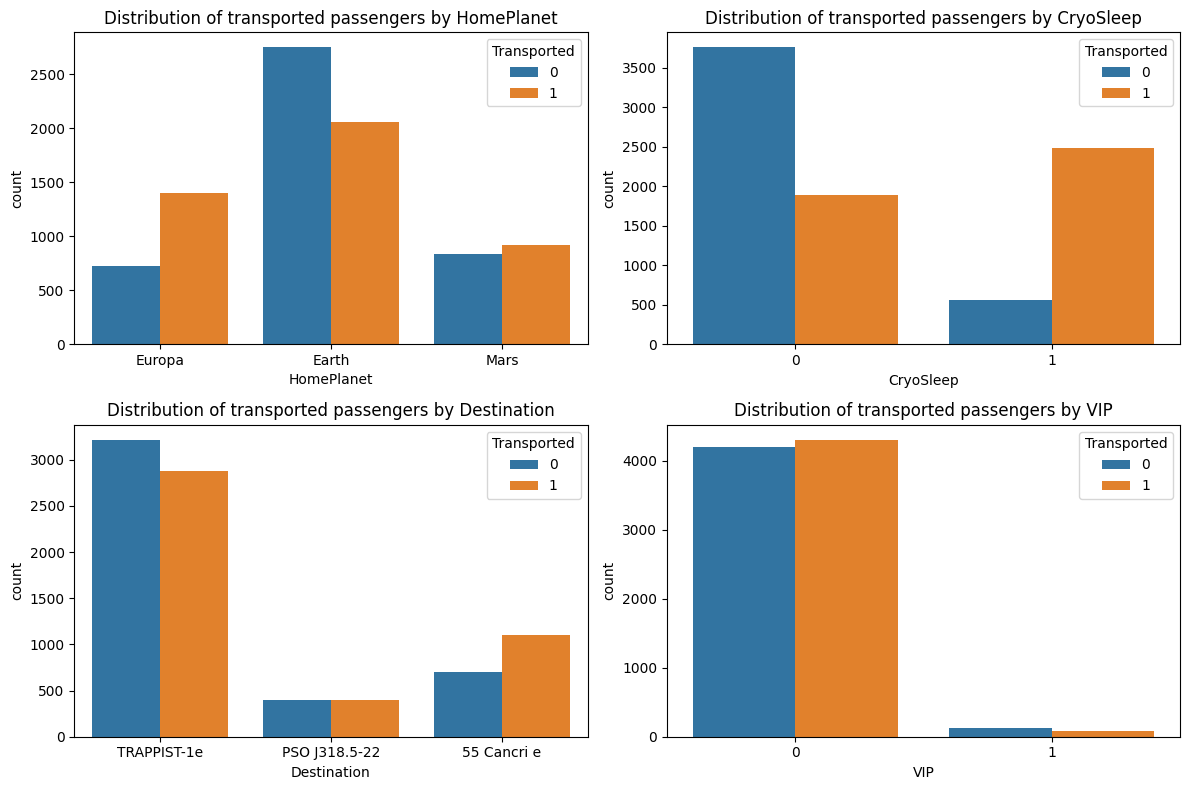

In [168]:
# Adjust the global size
plt.figure(figsize=(12, 8))

# Subplot 1: HomePlanet
plt.subplot(2, 2, 1)
sns.countplot(x='HomePlanet', data=train_data, hue='Transported')
plt.title('Distribution of transported passengers by HomePlanet')

# Subplot 2: CryoSleep
plt.subplot(2, 2, 2)
sns.countplot(x='CryoSleep', data=train_data, hue='Transported')
plt.title('Distribution of transported passengers by CryoSleep')

# Subplot 3: Destination
plt.subplot(2, 2, 3)
sns.countplot(x='Destination', data=train_data, hue='Transported')
plt.title('Distribution of transported passengers by Destination')

# Subplot 4: VIP
plt.subplot(2, 2, 4)
sns.countplot(x='VIP', data=train_data, hue='Transported')
plt.title('Distribution of transported passengers by VIP')

plt.tight_layout() 
plt.show()

From the plots above, it can be seen that the features HomePlanet and Cryosleep are more relevant to predict the transportation. On the other hand, the Destination and the VIP features seem less important.

### 4.2. Numerical features

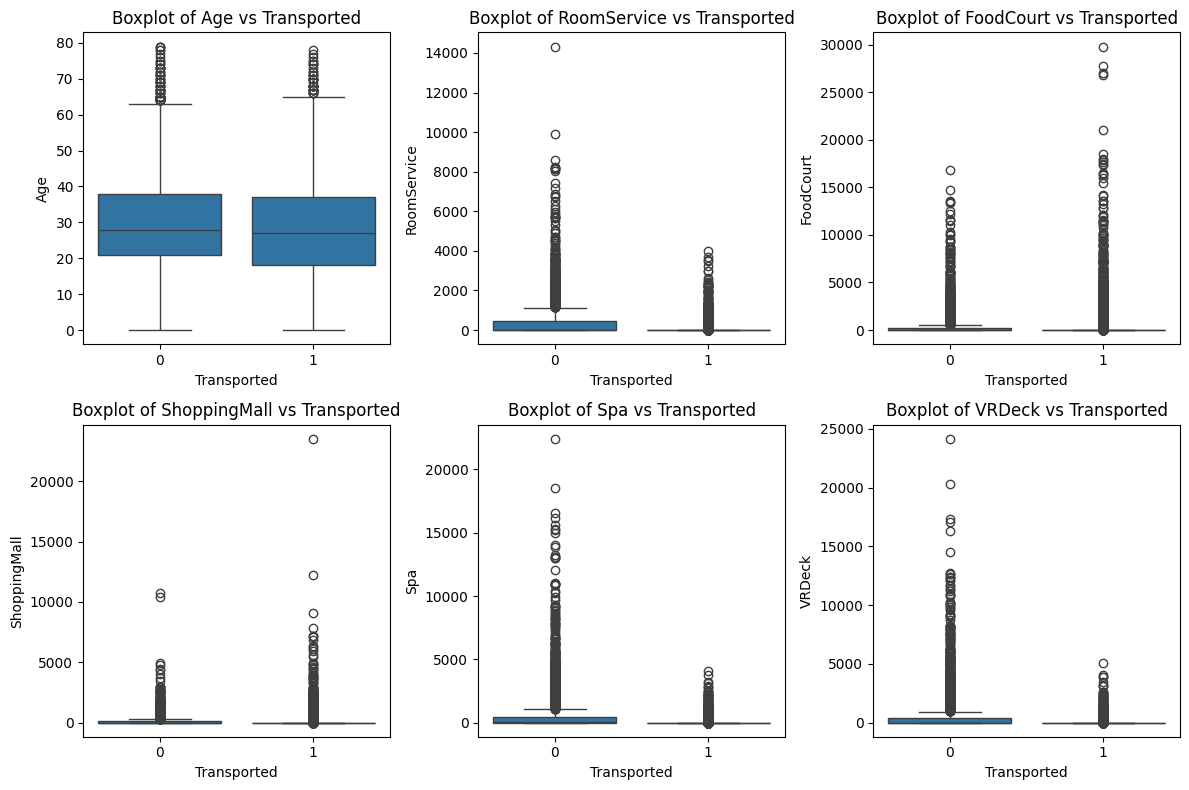

In [169]:
# Adjust the global size
plt.figure(figsize=(12, 8))

# Age vs Transported
plt.subplot(2, 3, 1)
sns.boxplot(x='Transported', y='Age', data=train_data)
plt.title('Boxplot of Age vs Transported')

# RoomService vs Transported
plt.subplot(2, 3, 2)
sns.boxplot(x='Transported', y='RoomService', data=train_data)
plt.title('Boxplot of RoomService vs Transported')

# FoodCourt vs Transported
plt.subplot(2, 3, 3)
sns.boxplot(x='Transported', y='FoodCourt', data=train_data)
plt.title('Boxplot of FoodCourt vs Transported')

# ShoppingMall vs Transported
plt.subplot(2, 3, 4)
sns.boxplot(x='Transported', y='ShoppingMall', data=train_data)
plt.title('Boxplot of ShoppingMall vs Transported')

# Spa vs Transported
plt.subplot(2, 3, 5)
sns.boxplot(x='Transported', y='Spa', data=train_data)
plt.title('Boxplot of Spa vs Transported')

# VRDeck vs Transported
plt.subplot(2, 3, 6)
sns.boxplot(x='Transported', y='VRDeck', data=train_data)
plt.title('Boxplot of VRDeck vs Transported')


plt.tight_layout() 
plt.show()

There isn't much to see in the plots. Let's zoom in the y axis.

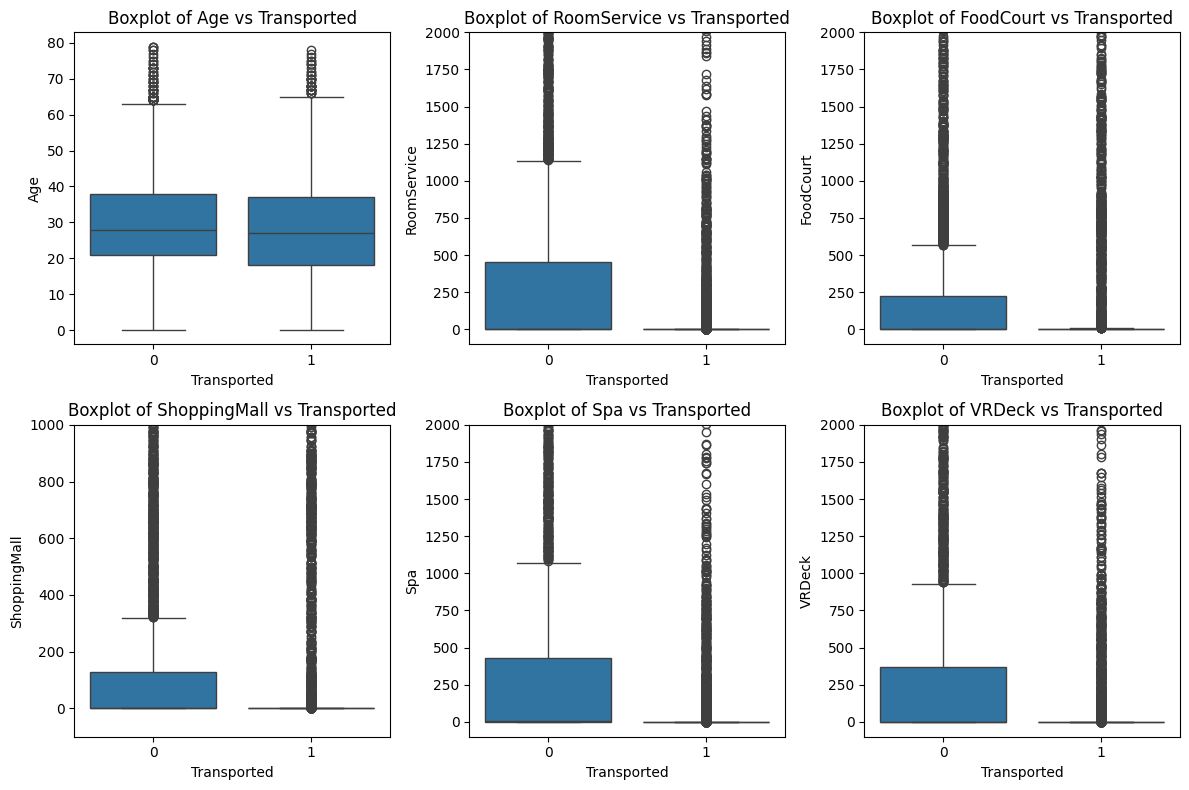

In [180]:
# Adjust the global size
plt.figure(figsize=(12, 8))

# Age vs Transported
plt.subplot(2, 3, 1)
sns.boxplot(x='Transported', y='Age', data=train_data)
plt.title('Boxplot of Age vs Transported')

# RoomService vs Transported
plt.subplot(2, 3, 2)
sns.boxplot(x='Transported', y='RoomService', data=train_data)
plt.title('Boxplot of RoomService vs Transported')
plt.ylim(-100, 2000)

# FoodCourt vs Transported
plt.subplot(2, 3, 3)
sns.boxplot(x='Transported', y='FoodCourt', data=train_data)
plt.title('Boxplot of FoodCourt vs Transported')
plt.ylim(-100, 2000)

# ShoppingMall vs Transported
plt.subplot(2, 3, 4)
sns.boxplot(x='Transported', y='ShoppingMall', data=train_data)
plt.title('Boxplot of ShoppingMall vs Transported')
plt.ylim(-100, 1000)

# Spa vs Transported
plt.subplot(2, 3, 5)
sns.boxplot(x='Transported', y='Spa', data=train_data)
plt.title('Boxplot of Spa vs Transported')
plt.ylim(-100, 2000)

# VRDeck vs Transported
plt.subplot(2, 3, 6)
sns.boxplot(x='Transported', y='VRDeck', data=train_data)
plt.title('Boxplot of VRDeck vs Transported')
plt.ylim(-100, 2000)


plt.tight_layout() 
plt.show()

Although there isn't much difference in the `Age` boxplot for transported and not transported passengers, we can clearly see that half of the transported passengers are concentrated in a smaller range closer to 0 for the other variables.

### 4.3. Correlation Matrix

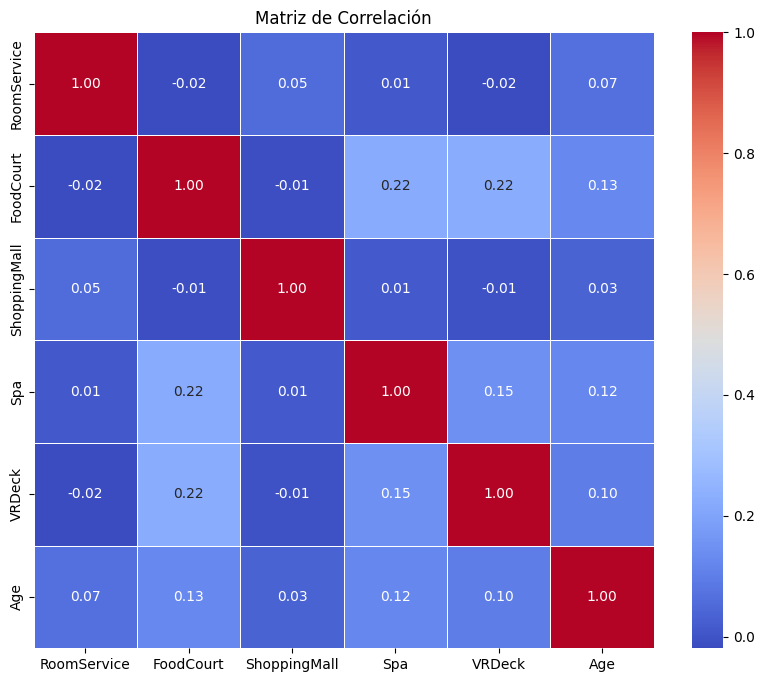

In [181]:
# Calculamos la correlación entre las variables numéricas
corr = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Age']].corr()

# Heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

There is almost no correlation between the numerical features.

### 4.4. Transported distribution

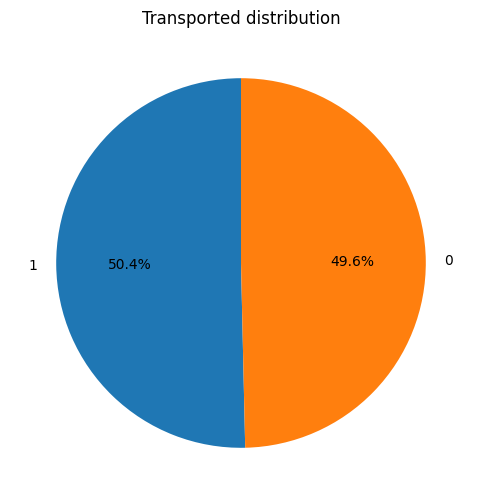

In [182]:
# Circular plot of transported
transported_counts = train_data['Transported'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(transported_counts, labels=transported_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Transported distribution')
plt.show()


Approximately half of the passengers were transported to the other dimension.

## 5. Prepare the dataset

We will drop `PassengerId` and `Name` columns as they cannot be involved in the transportation.

In [183]:
train_data = train_data.drop(['PassengerId', 'Name'], axis=1)
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,PassengerNumber,CabinDeck,CabinNum,CabinSide
0,Europa,0,TRAPPIST-1e,39.0,0,0,0,0,0,0,0,1,1,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109,9,25,549,44,1,2,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43,3576,0,6715,49,0,3,1,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0,1283,371,3329,193,0,3,2,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303,70,151,565,2,1,4,1,F,1,S


In addition, the scikit-learn machine learning algorithms require that all the features are numerical. Therefore, we should encode the categorical variables first.

In [184]:
# Separate the features and target
X = train_data.drop(columns=['Transported'])
y = train_data['Transported']

# Identify the categorical and numerical columns
categorical_features = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
numerical_features = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupNumber', 'PassengerNumber', 'CabinNum']

# Preporcessor for the One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('numerical', 'passthrough', numerical_features)
    ],
)

# Transform the datasets
X_transformed = preprocessor.fit_transform(X)
test_data_transformed = preprocessor.fit_transform(test_data)

# Get the names of the new columns
raw_feature_names = preprocessor.get_feature_names_out()
feature_names = [
    name.replace("categorical__", "").replace("numerical__", "")
    for name in raw_feature_names
]

# Convert back to DataFrame
X_transformed = pd.DataFrame(X_transformed, columns=feature_names)
test_data_transformed = pd.DataFrame(test_data_transformed, columns=feature_names)

Let us now split the train dataset into train anc cv (cross validation) datasets.

In [185]:
# Split in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1)

print(f'Examples in the train set: {len(X_train)}.')
print(f'Examples in the test set: {len(X_test)}.')  # This is, actually, teh cross validation dataset

Examples in the train set: 6954.
Examples in the test set: 1739.


## 6. Models

The models we have chosen for fitting the data are listed here:

1. [Decision Tree Classifier](#decision-tree-classifier)
2. [Random Forest Classifier](#random-forest-classifier)
3. [Gradient Boosted Decision Trees - XGBoost](#gradient-boosted-decision-tree)
4. [Extremely Randomized Trees](#extremely-randomized-trees)
5. [Neural Networks](#neural-networks)

<a id="decision-tree-classifier"></a>
### 6.1. Decision Tree Classifier

The Decision Tree Classifier is a simple and interpretable model that is particularly useful for problems with complex relationships between input features. It splits the data based on feature values, creating a tree-like structure. The model is easy to understand and visualize, making it suitable for initial explorations of the data. However, Decision Trees are prone to overfitting, especially when they are deep.

#### First contact

In [22]:
# Create the model
model = DecisionTreeClassifier(max_depth=5, random_state=1)

# Train the model
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [23]:
# Evaluate the model
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Accuracy of the Decision Tree Classifier:", score)

Accuracy of the Decision Tree Classifier: 0.7596319723979299


#### Parameters optimization

In [24]:
# What is the best value for max_depth?
max_depth_values = np.arange(1, 21)

# List to store the accuracies
accuracies = []

# Evaluate the model for each max_depth value
for depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

best_max_depth = max_depth_values[np.argmax(accuracies)]
print(f"Best value for max_depth: {best_max_depth}")
print(f"Precision for the best max_depth: {max(accuracies):.4f}")

Best value for max_depth: 9
Precision for the best max_depth: 0.7855


#### Final version

In [186]:
# Create the best model
model_1_dtc = DecisionTreeClassifier(max_depth=7, random_state=1)

# Train the best model
model_1_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=1)

In [187]:
# Evaluate the model
y_pred_1_dtc = model_1_dtc.predict(X_test)
score_1_dtc = accuracy_score(y_test, y_pred_1_dtc)
print("Accuracy of the Decision Tree Classifier:", score_1_dtc)

Accuracy of the Decision Tree Classifier: 0.7780333525014376


<a id="random-forest-classifier"></a>
### 6.2. Random Forest Classifier

Random Forest is an ensemble method that combines multiple Decision Trees to reduce the risk of overfitting and increase prediction accuracy. Each tree in the forest is trained on a random subset of the data, and the final prediction is made by averaging the predictions of all trees (for regression) or by voting (for classification). This model is robust to overfitting, handles high-dimensional datasets well, and is effective for both classification and regression tasks. Random Forests tend to perform well without requiring extensive hyperparameter tuning.

#### First contact

In [27]:
# Create the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=1)

In [28]:
# Evaluate the model
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Accuracy of the Decision Tree Classifier:", score)

Accuracy of the Decision Tree Classifier: 0.8125359401955147


#### Parameters optimization

In [35]:
# What are the best values for the parameters?
# Using GridSearchCV

# Define the model
model = RandomForestClassifier(random_state=1)

# Define the values to test
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [5, 10, 15, None],  # max_depth of the trees
    'min_samples_split': [2, 5, 10],  # Min number of required samples to divide a node
    'min_samples_leaf': [1, 2, 4],  # Min number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when dividing a node
}

# Use GridSearchCV to perform the search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Evaluate the model with the best params
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy with the best parameters: 0.8108108108108109


In [36]:
# What are the best values for the parameters?
# Using RandomizedSearchCV

# Define the model
model = RandomForestClassifier(random_state=1)

# Define the values to test
param_dist = {
    'n_estimators': np.arange(50, 201, 10),  # Number of trees in the forest
    'max_depth': [5, 10, 15, None],  # max_depth of the trees
    'min_samples_split': [2, 5, 10],  # Min number of required samples to divide a node
    'min_samples_leaf': [1, 2, 4],  # Min number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when dividing a node
}

# Use RandomizedSearchCV to perform the search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=500, cv=5, n_jobs=-1, verbose=0)

# Fit the model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# Evaluate the model with the best params
best = random_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
Accuracy with the best parameters: 0.8108108108108109


#### Final version

In [188]:
# Create the model
model_2_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15, 
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=1
)

# Train the model
model_2_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1)

In [189]:
# Evaluate the model
y_pred_2_rf = model_2_rf.predict(X_test)
score_2_rf = accuracy_score(y_test, y_pred_2_rf)
print("Accuracy of the Decision Tree Classifier:", score_2_rf)

Accuracy of the Decision Tree Classifier: 0.8108108108108109


<a id="gradient-boosted-decision-tree"></a>
### 6.3. Gradient Boosted Decision Trees - XGBoost

XGBoost is one of the most powerful and widely-used models for tabular data due to its ability to handle missing values, outliers, and interactions between features effectively. It builds decision trees sequentially, where each tree corrects the errors of the previous one, using the gradient boosting technique. XGBoost is known for its high performance, scalability, and speed, and it has been proven to work well in many real-world applications. The model can be more prone to overfitting if not tuned properly, but it often yields superior results compared to simpler models.

#### First contact

In [223]:
# Create the model
model = XGBClassifier(n_estimators=100, max_depth=5, random_state=1)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [46]:
# Evaluate the model
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Accuracy of the Decision Tree Classifier:", score)

Accuracy of the Decision Tree Classifier: 0.8039102932719954


#### Parameters optimization

In [48]:
# What are the best values for the parameters?
# Using GridSearchCV

# Define the model
model = XGBClassifier(random_state=1)

# Define the values to test
param_grid = {
    'n_estimators': [50, 100, 200],     # Number of trees in the forest
    'max_depth': [5, 10, 15, None],     # max_depth of the trees
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'subsample': [0.8, 1.0],            # Rate of samples used in each tree
    'colsample_bytree': [0.8, 1.0]      # Rate of features used
}

# Use GridSearchCV to perform the search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=3,         
    verbose=0,
    n_jobs=-1  # Use all teh available cores
)

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Evaluate the model with the best params
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Accuracy with the best parameters: 0.8108108108108109


In [50]:
# What are the best values for the parameters?
# Using RandomizedSearchCV

# Define the model
model = XGBClassifier(random_state=1)

# Define the values to test
param_dist = {
    'n_estimators': np.arange(50, 201, 10),       # Number of trees in the forest
    'max_depth': np.arange(3, 15),                # max_depth of the trees
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Learning rate
    'subsample': np.linspace(0.6, 1.0, 5),        # Rate of samples used in each tree
    'colsample_bytree': np.linspace(0.6, 1.0, 5)  # Rate of features used
}

# Use RandomizedSearchCV to perform the search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=500,           
    scoring='accuracy',
    cv=3,
    verbose=0,
    random_state=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# Evaluate the model with the best params
best = random_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.1711111111111111, 'colsample_bytree': 0.6}
Accuracy with the best parameters: 0.8177113283496262


#### Final version

In [238]:
# Create the best model
model_3_xgb = XGBClassifier(
    n_estimators=150, 
    max_depth=3,
    subsample=1.0,
    learning_rate=0.3,
    colsample_bytree=0.8,
    random_state=1
)

# Train the model
model_3_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [239]:
# Evaluate the model
y_pred_3_xgb = model_3_xgb.predict(X_test)
score_3_xgb = accuracy_score(y_test, y_pred_3_xgb)
print("Accuracy of the Decision Tree Classifier:", score_3_xgb)

Accuracy of the Decision Tree Classifier: 0.8234617596319724


<a id="extremely-randomized-trees"></a>
### 6.4. Extremely Randomized Trees

Extremely Randomized Trees, or ExtraTrees, is an ensemble learning method similar to Random Forests. The key difference is that ExtraTrees introduces more randomness into the model by randomly selecting thresholds for splitting nodes in each tree, rather than optimizing the best split. This makes ExtraTrees a faster and often more robust alternative to Random Forests. It tends to be less prone to overfitting and is efficient in handling high-dimensional datasets with a large number of features. Like Random Forests, ExtraTrees also works well without extensive parameter tuning.

#### First contact

In [67]:
# Create the model
model = ExtraTreesClassifier(n_estimators=100, max_depth=5, random_state=1)

# Train the model
model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=5, random_state=1)

In [68]:
# Evaluate the model
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Accuracy of the Decision Tree Classifier:", score)

Accuracy of the Decision Tree Classifier: 0.7475560667050029


#### Parameters optimization

In [74]:
# What are the best values for the parameters?
# Using GridSearchCV

# Define the model
model = ExtraTreesClassifier(random_state=1)

# Define the values to test
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20],  # max_depth of the trees
    'min_samples_split': [2, 5, 10],  # Min number of required samples to divide a node
    'min_samples_leaf': [1, 2, 4],  # Min number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when dividing a node
}

# Use GridSearchCV to perform the search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Evaluate the model with the best params
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy with the best parameters: 0.8039102932719954


In [79]:
# What are the best values for the parameters?
# Using RandomizedSearchCV

# Define the model
model = ExtraTreesClassifier(random_state=1)

# Define the values to test
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Use RandomizedSearchCV to perform the search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=500, cv=5, scoring='accuracy', verbose=0, random_state=1, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# Evaluate the model with the best params
best = random_search.best_estimator_
y_pred = best.predict(X_test)
print("Accuracy with the best parameters:", accuracy_score(y_test, y_pred))

Best parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 80}
Accuracy with the best parameters: 0.8096607245543416


#### Final version

In [192]:
# Create the best model
model_4_ert = ExtraTreesClassifier(
    n_estimators=200, 
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    max_features='sqrt',
    random_state=1)

# Train the model
model_4_ert.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                     random_state=1)

In [193]:
# Evaluate the model
y_pred_4_ert = model_4_ert.predict(X_test)
score_4_ert = accuracy_score(y_test, y_pred_4_ert)
print("Accuracy of the Decision Tree Classifier:", score_4_ert)

Accuracy of the Decision Tree Classifier: 0.8039102932719954


<a id="neural-networks"></a>
### 6.5. Neural Networks

Neural Networks are powerful models capable of capturing complex relationships in large datasets. In particular, for problems where feature interactions are highly non-linear or involve intricate patterns, neural networks excel. They require significant amounts of data to train effectively and can be sensitive to hyperparameter tuning. While neural networks are not always the best choice for smaller datasets (where simpler models might outperform), they can be very effective in cases with large and complex data, such as image, text, or time series data. In this context, they offer a flexible and powerful tool for achieving high predictive performance.

In [194]:
# Numerical features to scale
#numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupNumber', 'PassengerNumber', 'CabinNum']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum']

# Scale de data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)  # Only include numerical features
    ], remainder='passthrough' 
)

# Drop columns: GroupNumber, PassengerNumber
X_train_aux = X_train.drop(['GroupNumber', 'PassengerNumber'], axis=1)
X_test_aux = X_test.drop(['GroupNumber', 'PassengerNumber'], axis=1)
test_data_transformed_aux = test_data_transformed.drop(['GroupNumber', 'PassengerNumber'], axis=1)

# Apply the preprocessor
X_train_scaled = preprocessor.fit_transform(X_train_aux)
X_test_scaled = preprocessor.transform(X_test_aux)
test_data_scaled_nn = preprocessor.transform(test_data_transformed_aux)

In [195]:
# Create the model
model_5_nn = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='linear') 
])

# Compile the model
model_5_nn.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss=BinaryCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

# Fit the model
history = model_5_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5002 - loss: 0.8433 - val_accuracy: 0.5090 - val_loss: 0.7793
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5571 - loss: 0.7489 - val_accuracy: 0.7498 - val_loss: 0.6583
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.6425 - val_accuracy: 0.7671 - val_loss: 0.5943
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7725 - loss: 0.5890 - val_accuracy: 0.7714 - val_loss: 0.5711
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.5738 - val_accuracy: 0.7771 - val_loss: 0.5577
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - loss: 0.5675 - val_accuracy: 0.7779 - val_loss: 0.5479
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.5461 - val_accuracy: 0.7757 - val_loss: 0.5396
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.5349 - val_accuracy: 0.

In [196]:
# Evaluate the model
y_pred_5_nn = tf.nn.sigmoid(model_5_nn(X_test_scaled)).numpy()
y_pred_5_nn = (y_pred_5_nn > 0.5).astype(int)
score_5_nn = accuracy_score(y_test, y_pred_5_nn)
print("Accuracy of the Decision Tree Classifier:", score_5_nn)

Accuracy of the Decision Tree Classifier: 0.8073605520414031


## 7. Submission

Now that we have trained all the models, we can compare their accuracies.

In [198]:
print(f'Model 1: Decision Tree Classifier \n\t Accuracy = {score_1_dtc}\n')
print(f'Model 2: Random Forest Classifier \n\t Accuracy = {score_2_rf}\n')
print(f'Model 3: Gradient Boosted Decision Trees - XGBoost \n\t Accuracy = {score_3_xgb}\n')
print(f'Model 4: Extremely Randomized Trees \n\t Accuracy = {score_4_ert}\n')
print(f'Model 5: Neural Networks \n\t Accuracy = {score_5_nn}\n')

Model 1: Decision Tree Classifier 
	 Accuracy = 0.7780333525014376

Model 2: Random Forest Classifier 
	 Accuracy = 0.8108108108108109

Model 3: Gradient Boosted Decision Trees - XGBoost 
	 Accuracy = 0.8234617596319724

Model 4: Extremely Randomized Trees 
	 Accuracy = 0.8039102932719954

Model 5: Neural Networks 
	 Accuracy = 0.8073605520414031



The XGBoost model achieves the highest accuracy, likely because the dataset is not large enough for a neural network model to outperform it. Therefore, we will use the XGBoost model to generate the predictions for the `test_data`.

In [199]:
# Predictions for test_data
y_pred = model_3_xgb.predict(test_data_transformed)

In [213]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['Transported']
y_pred_df.head()

,Transported
0,1
1,0
2,1
3,1
4,1


In [214]:
test_data = pd.read_csv('data/test.csv')
test_data = test_data[['PassengerId']]
test_data.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


In [219]:
# Merge the passengers IDs with their predictions
test_data_pred = pd.concat([test_data, y_pred_df], axis=1)
test_data_pred['Transported'] = test_data_pred['Transported'].astype(bool)
test_data_pred.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [221]:
test_data_pred.to_csv('kaggle_submission.csv', index=False)